In [1]:
#Chapter 6 Learning Best Practices for Model Evaluation and Hyperparameter Tuning

#Streamlining workflows with pipelines
#the 'Pipeline' class in scikit-learn allows us to fit a model including an arbitrary number of transformation steps and apply it to make predictions about new data
#Loading the Breast Cancer Wisconsin dataset
#M=malignant, B=benign
#Columns 3-32 contain 30 real valued features that have been computed from digitalized images of the cell nuclei, 
#which can be used to build a model to predict whether a tumor is benign or malinant

#first of all, we will read in the dataset and split it into training and testing datasets

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
df.shape

(569, 32)

In [3]:
#assign the 30 features to a NumPy array x.
#Using a Label Encoder object, 
#we transform the class labels from their original string representation ('M','B') into integers

from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

#After encoding the class labels (diagnosis) in array y,
#the maglignant tumors are now represented as class 1, 
#and the benign tumor are represented as class 0

array(['B', 'M'], dtype=object)

In [4]:
#double-check this mapping by calling the transform method of the fitted LabelEncoder
le.transform(['M','B'])

array([1, 0])

In [5]:
#Before construct our first model pipeline,
#divide the dataset into a separate training dataset (80%) and a separate test dataset (20%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [6]:
#Combining transformers and estimators in a pipeline

#1.standardize the columns before we feed them to a linear classifier
#2.assume we want to compress our data from the initial 30 dimentions onto a lower 2-dimensional subspace via PCA

#Instead of going through the fitting and transform steps for the training and test datasets separately
#we can chain the StandardScaler, PCA, and LogisticRegression objects in a pipeline:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#'make_pipeline' takes an arbitrary number of scikit-learn transformers
#(objects that support the fit and transform methods as input)
#followed by a scikit-learn estimator that implements the fit and predicts methods
#is a meta-estimator or wrapper around those individual transformers and estimators

#pipe_lr.fit: the data will be passed down a series of transformers via fit and transform calls on these intermediate steps 
#until it arrives the estimator objects
#the estimators will then be fitted to the transformed training data

#the last pipeline element has to be an estimator

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))
pipe_lr.fit(X_train,y_train)

#pipe_lr.predict: the data will pass through the intemediate steps via transform call.
#In the final step, the estimator object will return a prediction on the transformed data
y_pred = pipe_lr.predict(X_test)



print('Test Accuracy: %.3f' % pipe_lr.score(X_test,y_test))

Test Accuracy: 0.956


In [7]:
#Using k-fold cross validation to assess model performance
#1. Randomly split the training dataset into k folds without replacement,
# where (k-1) folds are used for the model training and one fold is used for performance valuation
#2. Step 1 repeated k times so that we obtain k models and performance estimates
#3. Calculate the average performance of the models based on the different, independent folds to 
#   obtain a performance estimate that is less sensitive to the sub-partitioning of the training data

#Typically, we use k-fold cross-validation for model tuning - finding the optimal hyperparameter
#Once we have found satisfactory hyperparameter valus, we can retrain the model on the complete training set and obtain a final performance estimate using the independent test set

#Rationale: providing more training sample, more accurate and more robust
#A good standard value for k in k-fold cross-validation is 10
#high k, low bias, high variance; low k, high bias, low variance

#Stratified k-fold cross-validation
#preserved the class proportions
#each fold is representative of the class proportions in the training dataset

import numpy as np

from sklearn.model_selection import StratifiedKFold

#initialize the StratifiedKfold iterator
#specify the number of folds via the n_splits parameter
kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train,y_train)
scores = []
for k, (train,test) in enumerate(kfold):
    #loop through k fold
    #used the returned indices in train to fit the logistic regression pipeline
    pipe_lr.fit(X_train[train],y_train[train])
    #use the test indice the calculate the accuracy score of the model
    score = pipe_lr.score(X_train[test],y_train[test])
    #collected in the scores list to calculate the average accuracy and the standard deviation of the estimate
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]),score))
    
print('\nCV accurary: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accurary: 0.950 +/- 0.014


In [8]:
#scikit-learn's implementation of k-fold cross-validation scorer

from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1) #n_jobs, CPU
print('CV accuracy scores: %s'% scores)

print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


In [9]:
#Debugging algorithms with learning curves

#Diagnosing bias and variance problems with learning curves
#plotting the model training and validation accuracies as function of the training set size
#detect whether the model suffers from high variance or high bias and whether collection of more data could help address this problem

#High Bias = underfitting: 1)increase the no. of parameters, collecting or constructing additional features; 2)by decreasing the degree of regularization
#High Variance = overfitting: 1)collect more training data, 2)reduce the complexity of the model (feature selection & feature extraction), 3)increase the regularization parameter

import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2',random_state=1))

train_sizes, train_scores, test_scores = \
                            learning_curve(estimator=pipe_lr,
                                           X=X_train,
                                           y=y_train,
                                           train_sizes=np.linspace(0.1,1.0,10), #from 10% to 100% of the dataset, 10 samples
                                           cv=10, #10-fold stratified CV
                                           n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.03])
plt.show()

<Figure size 640x480 with 1 Axes>

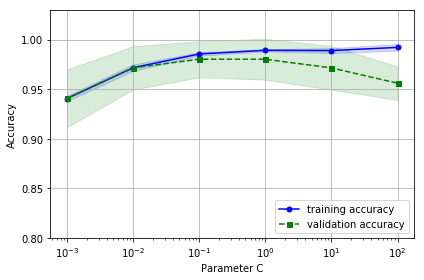

In [10]:
#Addressong over- and underfitting with validation curves
#Unlike learning curves plotting the training and test accuracies as functions of the sample size
#Validation curves vary the values of the model parameters, for example, the inverse regularization parameter C in logistic regression

from sklearn.model_selection import validation_curve

param_range = [0.001,0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator = pipe_lr,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'logisticregression__C', #inverse regularization parameter of the LogisticRegression Classifier
                                             param_range = param_range,
                                             cv = 10) #stratified k-fold
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(param_range, train_mean,
         color = 'blue', marker = 'o',
         markersize=5, label='training accuracy')

plt.fill_between(param_range,train_mean+train_std,
                 train_mean-train_std, alpha = 0.15, color = 'blue')

plt.plot(param_range, test_mean,
         color = 'green', marker = 's', linestyle='--',
         markersize=5, label='validation accuracy')

plt.fill_between(param_range,test_mean+test_std,
                 test_mean-test_std, alpha = 0.15, color = 'green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.03])
plt.tight_layout()
plt.show()


In [13]:
#Fine-tuning machine learning models via grid search

#Brute-force exhaustive search
#specify a list of values for different hyperparameters
#evaluate the model performance for each combination of those to obtain the optimal combination of values from this set

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_grid = [{'svc__C':param_range,
               'svc__kernel': ['linear']},
              {'svc__C':param_range,
               'svc__gamma': param_range, #specific to kernel SVMs
               'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1)

gs = gs.fit(X_train,y_train)
print(gs.best_score_) #best-k-fold cross-validation accuracy score of the best-performing model
print(gs.best_params_) #look at the best-performing model's parameter

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [14]:
#use the independent test dataset to estimate the performance of the best-selected model
clf = gs.best_estimator_
clf.fit(X_train,y_train)
print('Test accuracy: %.3f' % clf.score(X_test,y_test))

Test accuracy: 0.974


In [16]:
#Algorithm selection with nested cross-validation

#k-fold cv + grid search = fine-tuning the performance of a machine learning model by varying its hyperparameter values

#Select differentmachine learning algorithms: nested cross-validation
#True error of the estimate is almost unbiased relative to the test set

#Nested CV:
#Outer k-fold cv loop: split the data into training and test folds (Train with optimal parameters)
#Inner loop: select the model using k-fold cv on the training set (Tune parameter)
#After model selection, the test fold is then used to evaluate the model performance
#Common structure: 5 x 2 cross-validation

#In scikit-learn, we can perform nested cross-validation as follows:

#Inner loop to fine tune the parameters
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
#Outter loop to give an average accuracy of the model to the unseen data
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
#The returned average cross-validation accuracy gives us a good estimate of what to expect if we tune the hyperparameters of a model and use it on unseen data
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


CV accuracy: 0.974 +/- 0.015


In [18]:
#We can use the nested cross-validation approach to compare an SVM model to simple decision tree classifier
#for simplicity, we only tune its depth parameter

from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
                  scoring = 'accuracy',
                  cv = 2)
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.934 +/- 0.016


In [19]:
#Looking at different performance evaluation metrics
#Reading a confuction matrix
#[[Ture Positive, False Negative-type 1 error],
# [False positive-type 2 error, True negative]
#[[TP,FN],
# [FP,TN]]

from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


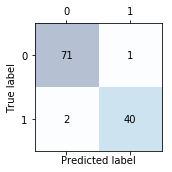

In [21]:
#Map this information onto the confusion matrix illustration in the previous figure 
#using Matplotlib's 'matshow' fucntion

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [27]:
#Additonal note: label issue

#remember we previously ecnode the class labels so that malignant is `positive' and benign is 'negative'

le.transform(['M','B'])



array([1, 0])

In [28]:
#To be consistent
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=[1,0])
print(confmat)

[[40  2]
 [ 1 71]]


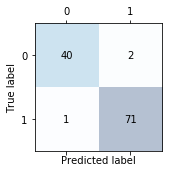

In [24]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [30]:
#Optimizing the precision and recall of a classification model

#Error(ERR): sum of the all false prediction divided by the no. of the total prediction
#ERR = (FP + FN)/ (FP+FN+TP+TN)

#Accuracy (ACC): sum of correct predictions divided by the total no. of prediction
#ACC = (TP+TN)/(FP+FN+TP+TN) = 1 - ERR

#True positive rate(TPR) = TP / (FN+TP)  ~ true positive/total no. true: fraction of positive (or relevant) samples that were correctly identified out of the total pool of positives
#False positive rate(FPR) = FP / (FP+TN) ~ false positive/total no. false:fraction of negative (or relevant) samples that were incorrectly identified out of the total pool of negatives
#they are useful for imbalanced class problems

#Precision(PRE) = TP / (TP+FP)
#Recall(REC) = TPR = TP/P = TP/(FN+TP)

#In practice, a combination of PRE and REC is used
#F1-score = 2 * (PRE x REC)/(PRE + REC)

from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test,y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test,y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test,y_pred=y_pred))



Precision: 0.976
Recall: 0.952
F1: 0.964


In [32]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score,pos_label=0) #Construct our own scorer via the make_scorer function

c_gamma_range=[0.01,0.1,1.0,10.0]

param_grid=[{'svc__C': c_gamma_range,
             'svc__kernel':['linear']},
            {'svc__C': c_gamma_range,
             'svc__gamma': c_gamma_range,
             'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer, #we can use F1 score instead of accuracy in GridSearch
                  cv = 10,
                  n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.9862021456964396
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


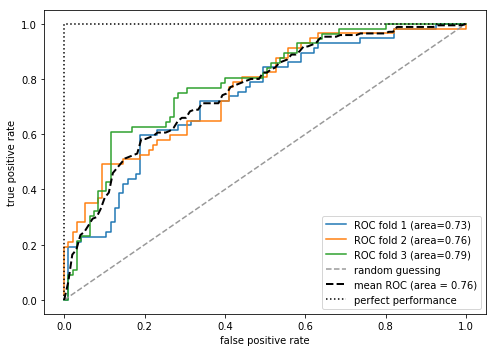

In [33]:
#Plotting a receiver operating characterisitics

#Receiver Operating Characteristics (ROC) graphs
#useful tool to select models for classification based on their performance with respect to the FPR and TPR
#computed by shifting the decision threshold of the classifier
#the diagonal of an ROC graph can be interpreted as random guessing
#classification models that fall below the diagonal are considered as worse than random guessing

#A perfect classifier would fall into the top left corner of the graph with a TPR of 1 and an FPR of 0
#Based on the ROC curve, we can then compute the ROC Area Under the Curve (ROC AUC) to characterize the performance of a classification model

#Similiar to ROC curves, we can also compute precision-recall curves for different probability thresholds of a classifier

#we will plot an ROC curve of a classfier that only uses two features from the Breast Cancer Wisconsin dataset to predict whether a tumor is benign or malignant
#we will use the same logistic regression pipeline
#we will make the classification task more challenging for the classifier so that the resulting ROC curve becomes visually more interesting
#So, we reducing the number of the folds in the StratifiedKFold validator to three

#Accuracy score can be interpreted as a single cut-off point on an ROC curve
#Accuracy score mostly agree with ROC AUC

from sklearn.metrics import roc_curve, auc
from scipy import interp

#Make pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),#Reduced to Two principal components
                        LogisticRegression(penalty='l2',
                                           random_state=1,
                                           C = 100.0))
#Only use two features from the dataset
X_train2 = X_train[:,[4,14]]
cv = list(StratifiedKFold(n_splits=3,
                          random_state=1).split(X_train,y_train))

fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []

for  i, (train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:,1],
                                     pos_label=1)
    #interpolate the average ROC curve from three folds
    mean_tpr += interp(mean_fpr,fpr,tpr) 
    mean_tpr[0] = 0.0
    #Calculate the area under the curve (roc_auc) of each CV
    roc_auc = auc(fpr,tpr)
    #Plot the performance of each CV
    plt.plot(fpr,tpr,label='ROC fold %d (area=%0.2f)' % (i+1,roc_auc))
    
#Random guessing, diagonal line
plt.plot([0,1],
         [0,1],
         linestyle='--',
         color = (0.6,0.6,0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)

#Plot Mean perforamnce
plt.plot(mean_fpr,mean_tpr,'k--',label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

#Plot Perfect performance
plt.plot([0,0,1],[0,1,1],linestyle=':',color='black',label='perfect performance')

#Legend, label stuff
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [34]:
#Scoring metrics for multiclass classification

#Over-versus-All (OvA) classification

#Micro-average: individual TPs, TNs, FPs, and FNs of the system
#useful if we want to weight each instance or prediction equally
#e.g. Micro Precision:
#PRE_micro = (TP_1+...+TP_k)/(TP_1+...TP_k+FP_1+...+FP_k)
#Marcro-average: avarege scores of the different systems
#useful if we wanna weight all classes equally to evaluate the overall performance of a classifir with regard to the most frequent class labels
#e.g Macro Precision:
#PRE_macro = (PRE_1+...+PRE_k)/k

#the weighted macro-avaerge is calculated by weighting the score of each class label
#by the number of true instances when calculating the average
#useful dealing with class imbalances, i.e. different numbers of instances for each label

#While the weighted macro-average is the default for multiclass problems in scikit-learn,
#we can specify the averaging method via the average parameter inside the different scoring functions

pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')



In [35]:
#Deal with class imbalance

#class imbalance:
#samples from one class or multiple classes are over-represented in a dataset

#Create an imbalanced dataset from our breast cancer dataset
X_imb = np.vstack((X[y==0],X[y==1][:40]))
y_imb = np.hstack((y[y==0],y[y==1][:40]))


In [36]:
#With this imbalance dataset, if we were to compute the accuracy of a model that 
#always predicts the majority class
#we would achieve a prediction accuracy of approximately 90%

y_pred = np.zeros(y_imb.shape[0]) #Create a zero vector that has a equal shape of the y
np.mean(y_pred == y_imb)*100

89.92443324937027

In [38]:
#Thus, when we fit classifiers on such datasets, 
#it would make sense to focus on other metrics than accuracy
#such as precision, recall, the ROC curve

#Problems with imbalance dataset
# 1) Misleading high accuracy
# 2) Decision rule is likely going to be biased towards the majority class (optimise the predictions based on the ost abundant class)

#Solution:
# 1) Assign a larger penalty to wrong predictions on the minority class
# 2) Upsampling the minority class, downsampling the majority class, the generation of synthetic training samples

#No best solution, better try out different strategies on a given problem, evaluate the resultss, and choose the technique that seems most appropriate

#Scikit-slearn has the 'resample' function to help with the upsampling of the minority class
#by drawing  new samples from the dataset with replacement
#The following code will take the minority class from our imbalanced breast cancer dataset and repeated draw new samples from it until it contains the same number of samples as the minority class

from sklearn.utils import resample

print('Number of class 1 samples before:', X_imb[y_imb==1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb==1],
                                    y_imb[y_imb==1],
                                    replace = True,
                                    n_samples=X_imb[y_imb==0].shape[0],
                                    random_state=123)

print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


In [39]:
X_bal=np.vstack((X[y==0],X_upsampled))
y_bal=np.hstack((y[y==0],y_upsampled))

In [40]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred==y_bal)*100

50.0